### INIT

In [ ]:
import sys
sys.path.insert(0, "home/fuu/sdb/fac-via-ppg/src")

In [ ]:
import numpy as np
from scipy.io.wavfile import read
import torch
from scipy import signal
from waveglow.denoiser import Denoiser

import torch
# waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_waveglow')

import IPython.display as ipd

In [ ]:
pwd

'/home/fuu/sdb/fac-via-ppg/test'

In [ ]:
cd /home/fuu/sdb/fac-via-ppg/src/script/

/home/fuu/sdb/fac-via-ppg/src/script


In [ ]:
# generate_synthesis.py [-h] --ppg2mel_model PPG2MEL_MODEL_PATH
#                            --waveglow_model WAVEGLOW_MODEL_PATH
#                            --teacher_utterance_path TEACHER_UTTERANCE_PATH
#                            --output_dir OUTPUT_DIR
#                            --named FILE_NAME

### 0628-Ⅰ P2M 模型检视

#### 0. INIT

In [ ]:
import sys 
sys.path.insert(0, "/home/fuu/sdb/fac-via-ppg/src/")

In [ ]:
# Library
from ppg import DependenciesPPG
from scipy.io import wavfile
from common import feat
from common import ppg

In [ ]:
# Get PPGs
def get_ppg(wav_path, deps):
    fs, wav = wavfile.read(wav_path)
    wave_data = feat.read_wav_kaldi_internal(wav, fs)
    seq = ppg.compute_full_ppg_wrapper(wave_data, deps.nnet, deps.lda, 10)
    return seq

# data to GPU
def to_gpu(x):
    x = x.contiguous()

    if torch.cuda.is_available():
        x = x.cuda(non_blocking=True)
    return torch.autograd.Variable(x)

def get_inference(seq, model, is_clip=False):
    """Tacotron inference.

    Args:
        seq: T*D numpy array.
        model: Tacotron model.
        is_clip: Set to True to avoid the artifacts at the end.

    Returns:
        synthesized mels.
    """
    # (T, D) numpy -> (1, D, T) cpu tensor
    seq = torch.from_numpy(seq).float().transpose(0, 1).unsqueeze(0)
    # cpu tensor -> gpu tensor
    seq = to_gpu(seq)
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(seq)
    if is_clip:
        return mel_outputs_postnet[:, :, 10:(seq.size(2)-10)]
    else:
        return mel_outputs_postnet

In [ ]:
"""
为了不让模型在计算ppg的时候炸掉，直接用抽取好的PPG
抽好的ppg格式是这样的 ppg_sequences.append(ppg_feat_pair[0].astype(np.float32))，get_ppg()抽取后再转换为np.float32

直接计算ppg中的ppg是直接使用get_ppg()抽取，不做其他处理
"""
import pickle
import numpy as np

from common.hparams_628 import create_hparams_stage
from script.train_ppg2mel_new import load_model
import torch


import matplotlib.pyplot as plt
import librosa.display
import librosa
%matplotlib inline

In [ ]:
# 载入预测模型
hparams = create_hparams_stage()
checkpoint_path = "/home/fuu/sdb/fac-via-ppg/output/6_28/bdl_p2m/checkpoint_69800"

tacotron_model = load_model(hparams)
tacotron_model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = tacotron_model.eval()

is_clip = False

In [ ]:
def plot_melspectrogram(S):
        """画出Mel谱"""
#         hop_length = 160
#         S = librosa.feature.melspectrogram(au, sr=self.sr, n_fft=4096, hop_length=hop_length)
        logS = librosa.power_to_db(abs(S))

        plt.figure(figsize=(15, 5))
        librosa.display.specshow(logS, sr=sr, hop_length=160, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')

#### 1. 用抽取好的ppg
会找不到对应的音频

In [ ]:
# 1. 不计算ppg
ppg_seq = []
fpath = "/home/fuu/sdb/fac-via-ppg/data/ppgmel_path/bdl_val/file_20_1.txt"

with open(fpath, 'rb') as f:
    data = pickle.load(f)
    ppg_seq = data[0]

teacher_ppg = ppg_seq[1]
# for i in ppg_seq:
#     print(np.shape(i))
print(np.shape(teacher_ppg))

(263, 5816)


In [ ]:
ac_mel = get_inference(teacher_ppg, tacotron_model, is_clip)

In [ ]:
ac_mel_np = ac_mel.cpu().detach().numpy()

In [ ]:
np.shape(ac_mel_np[0])

(80, 264)

In [ ]:
ac_mel_np_re = ac_mel_np[0]

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np

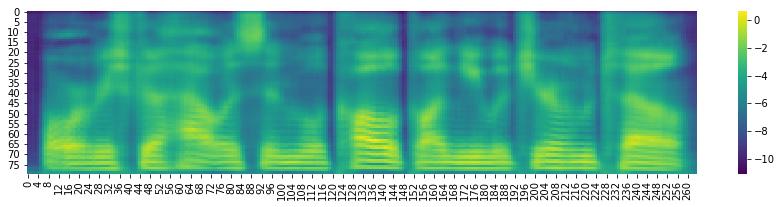

In [ ]:
# logS_0 = librosa.power_to_db(abs(S_0[::-1]))
# 生成的mel不需要power_to_db

plt.subplots(figsize=(15,3))
sns.heatmap(S_0[::-1], cmap='viridis')

plt.show()
plt.close()

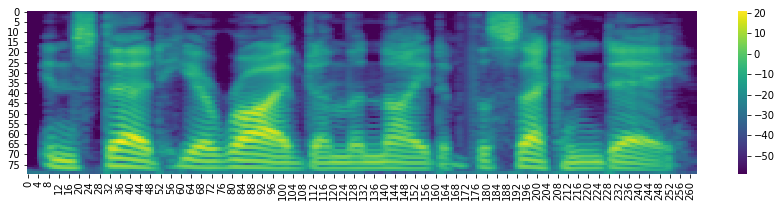

In [ ]:
logS_1 = librosa.power_to_db(abs(S_1[::-1]))

plt.subplots(figsize=(15,3))
sns.heatmap(logS_1, cmap='viridis')

plt.show()
plt.close()

#### 2. 计算PPG

##### 2-0 绘制测试 以/wav/arctic_b0532.wav为例

In [ ]:
# 1. 计算ppg
deps = DependenciesPPG()
teacher_utt_path = "/home/fuu/sdb/fac-via-ppg/data/cmu_us_bdl_arctic/wav/arctic_b0532.wav"
teacher_ppg_cal = get_ppg(teacher_utt_path, deps)

In [ ]:
# mel from model
mel_ac_cal = get_inference(teacher_ppg_cal, tacotron_model, is_clip)
mel_ac_cal_S_0 = mel_ac_cal.cpu().detach().numpy()[0]
mel_ac_cal_tS_0 = mel_ac_cal_S_0[::-1]
np.shape(mel_ac_cal_tS_0)

(80, 371)

In [ ]:
# mel from STFT
mel_au_cal, sr = librosa.load(teacher_utt_path, sr=16000)
mel_au_cal_S_1 = librosa.feature.melspectrogram(mel_au_cal, sr=sr, n_fft=1024, hop_length=160, n_mels=80)
mel_au_cal_logS_1 = librosa.power_to_db(abs(mel_au_cal_S_1[::-1]))
np.shape(mel_au_cal_logS_1)

(80, 370)

In [ ]:
mel_ac_cal_n = (mel_ac_cal_tS_0-np.min(mel_ac_cal_tS_0))/(np.max(mel_ac_cal_tS_0)-np.min(mel_ac_cal_tS_0))
np.shape(mel_ac_cal_n)

(80, 371)

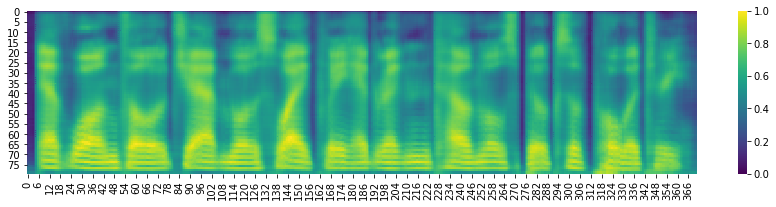

In [ ]:
# model
plt.subplots(figsize=(15,3))
sns.heatmap(mel_ac_cal_n, cmap='viridis')

plt.show()

In [ ]:
mel_au_cal_n = (mel_au_cal_logS_1-np.min(mel_au_cal_logS_1))/(np.max(mel_au_cal_logS_1)-np.min(mel_au_cal_logS_1))
np.shape(mel_au_cal_n)

(80, 370)

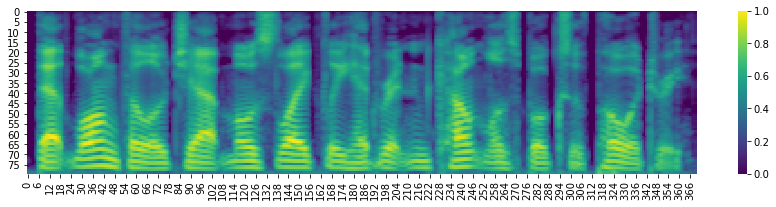

In [ ]:
# STFT
plt.subplots(figsize=(15,3))
sns.heatmap(mel_au_cal_n, cmap='viridis')

plt.show()

##### 2-1 绘制模块化 & 检视bdl_p2m_69800合成效果

In [ ]:
# b0533-b0539
# 未在train和val使用的数据path
path_33 = "/home/fuu/sdb/fac-via-ppg/data/cmu_us_bdl_arctic/wav/arctic_b0533.wav"
path_34 = "/home/fuu/sdb/fac-via-ppg/data/cmu_us_bdl_arctic/wav/arctic_b0534.wav"
path_35 = "/home/fuu/sdb/fac-via-ppg/data/cmu_us_bdl_arctic/wav/arctic_b0535.wav"
path_36 = "/home/fuu/sdb/fac-via-ppg/data/cmu_us_bdl_arctic/wav/arctic_b0536.wav"
path_37 = "/home/fuu/sdb/fac-via-ppg/data/cmu_us_bdl_arctic/wav/arctic_b0537.wav"
path_38 = "/home/fuu/sdb/fac-via-ppg/data/cmu_us_bdl_arctic/wav/arctic_b0538.wav"
path_39 = "/home/fuu/sdb/fac-via-ppg/data/cmu_us_bdl_arctic/wav/arctic_b0539.wav"

In [ ]:
# 载入预测模型
hparams = create_hparams_stage()
checkpoint_path = "/home/fuu/sdb/fac-via-ppg/output/6_28/bdl_p2m/checkpoint_69800"

tacotron_model = load_model(hparams)
tacotron_model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = tacotron_model.eval()

is_clip = False

In [ ]:
# Normalization
def MaxMinNormalization(X, Max, Min):
    X_n = (X - Min) / (Max - Min);
    return X_n;

# Preprocess mel data for plot
def preprocess_mel(path, tacotron_model):
    '''mel from model'''
    is_cal = 1
    if is_cal:
        deps = DependenciesPPG()
        teacher_utt_path = path
        teacher_ppg_cal = get_ppg(teacher_utt_path, deps)
    else:
        # 从磁盘读入
        pass
    mel_ac_cal = get_inference(teacher_ppg_cal, tacotron_model, is_clip)
    mel_ac_cal_S_0 = mel_ac_cal.cpu().detach().numpy()[0]
    mel_ac_cal_tS_0 = mel_ac_cal_S_0[::-1]
    
    model_mel = MaxMinNormalization(mel_ac_cal_tS_0, np.max(mel_ac_cal_tS_0), np.min(mel_ac_cal_tS_0))
    print("Shape of model mel:", np.shape(model_mel))
    
    '''mel from STFT'''
    mel_au_cal, sr = librosa.load(teacher_utt_path, sr=16000)
    mel_au_cal_S_1 = librosa.feature.melspectrogram(mel_au_cal, sr=sr, n_fft=1024, hop_length=160, n_mels=80)
    mel_au_cal_logS_1 = librosa.power_to_db(abs(mel_au_cal_S_1[::-1]))
    
    stft_mel = MaxMinNormalization(mel_au_cal_logS_1, np.max(mel_au_cal_logS_1), np.min(mel_au_cal_logS_1))
    print("Shape of stft mel:", np.shape(stft_mel))
    
    return model_mel, stft_mel

In [ ]:
# plot the Mel fig for model-mel and origin-mel
def draw_mel_pair(mel_list, path):
    fig, ax = plt.subplots(2,1, figsize=(15, 9), sharex=True) 
    titles = ["Model Mel", "STFT Mel"]
    for i, mel in enumerate(mel_list):
        p = sns.heatmap(mel, xticklabels=50, yticklabels=20, cmap='viridis', ax=ax[i]) 
        p.set_yticklabels([80,60,40,20])
        ax[i].set_title(titles[i] + " for " + "<" + path.split("data/")[1] + ">") 
        ax[i].set_ylabel("Channel")
        ax[i].set_xlabel("Frame")

In [ ]:
s33 = path_33.split("data/")
s33

['/home/fuu/sdb/fac-via-ppg/', 'cmu_us_bdl_arctic/wav/arctic_b0533.wav']

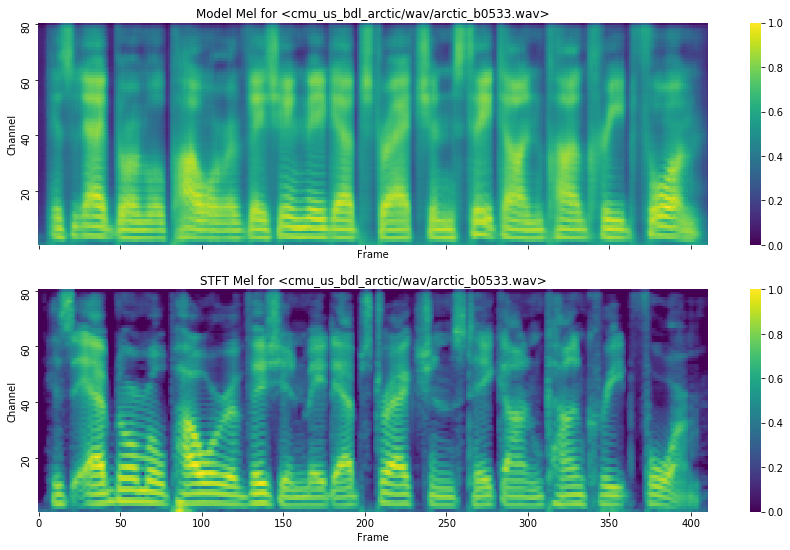

In [ ]:
mm_33, sm_33 = preprocess_mel(path_33, tacotron_model)
draw_mel_pair([mm_33, sm_33], path_33)

Shape of model mel: (80, 296)
Shape of stft mel: (80, 296)


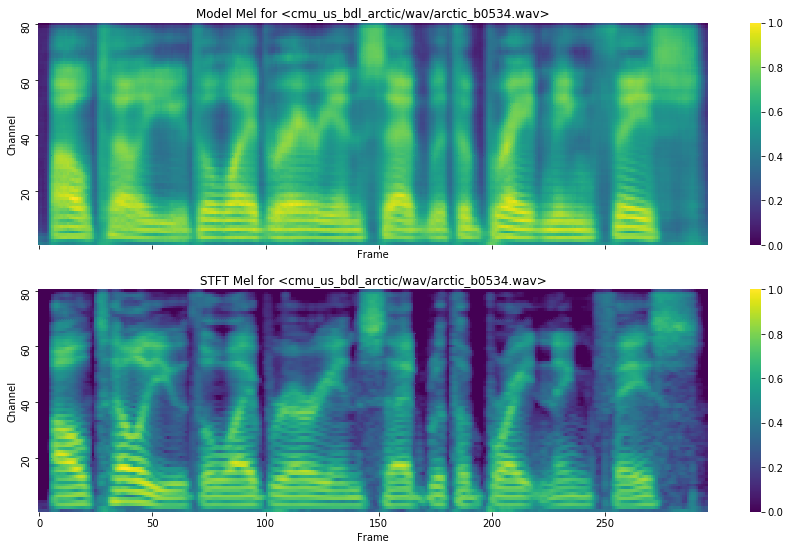

In [ ]:
m34 = preprocess_mel(path_34, tacotron_model)
draw_mel_pair(m34, path_34)

Shape of model mel: (80, 160)
Shape of stft mel: (80, 160)


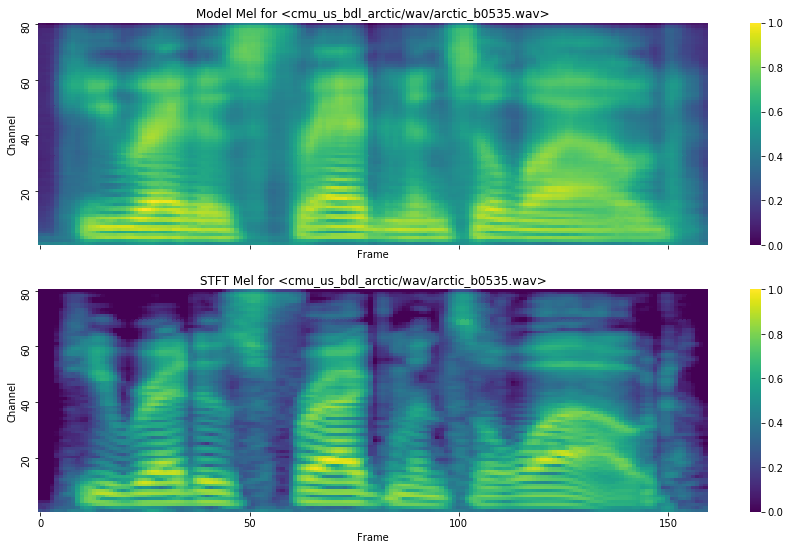

In [ ]:
m35 = preprocess_mel(path_35, tacotron_model)
draw_mel_pair(m35, path_35)

Shape of model mel: (80, 153)
Shape of stft mel: (80, 153)


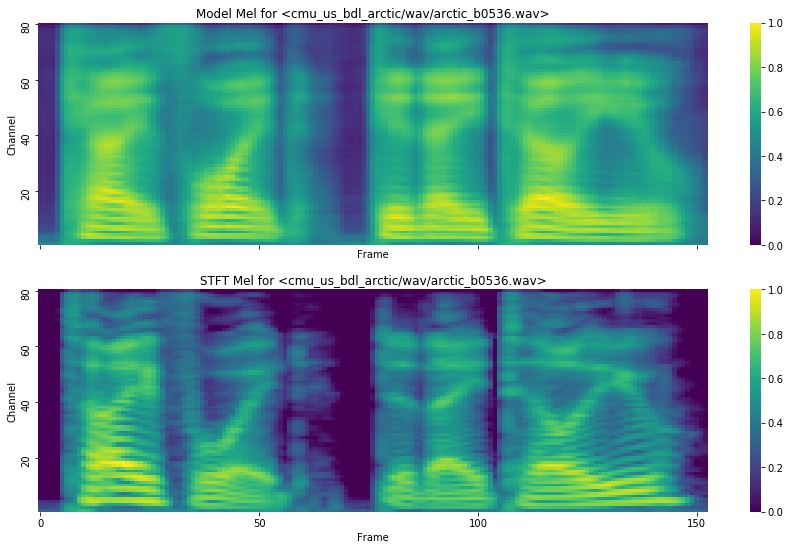

In [ ]:
m36 = preprocess_mel(path_36, tacotron_model)
draw_mel_pair(m36, path_36)

Shape of model mel: (80, 170)
Shape of stft mel: (80, 168)


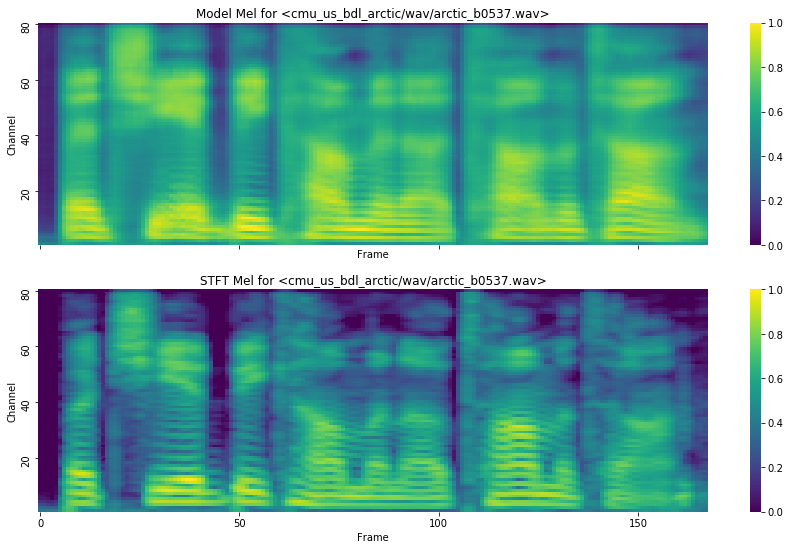

In [ ]:
m37 = preprocess_mel(path_37, tacotron_model)
draw_mel_pair(m37, path_37)

Shape of model mel: (80, 246)
Shape of stft mel: (80, 246)


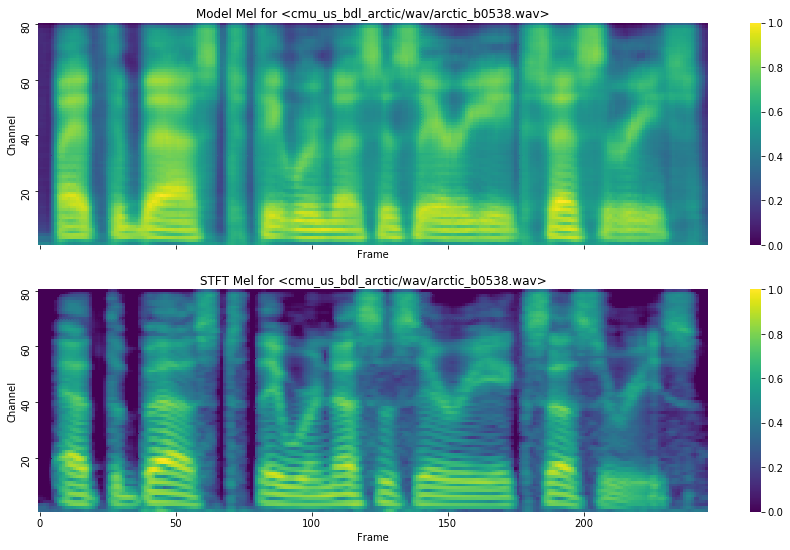

In [ ]:
m38 = preprocess_mel(path_38, tacotron_model)
draw_mel_pair(m38, path_38)

Shape of model mel: (80, 247)
Shape of stft mel: (80, 245)


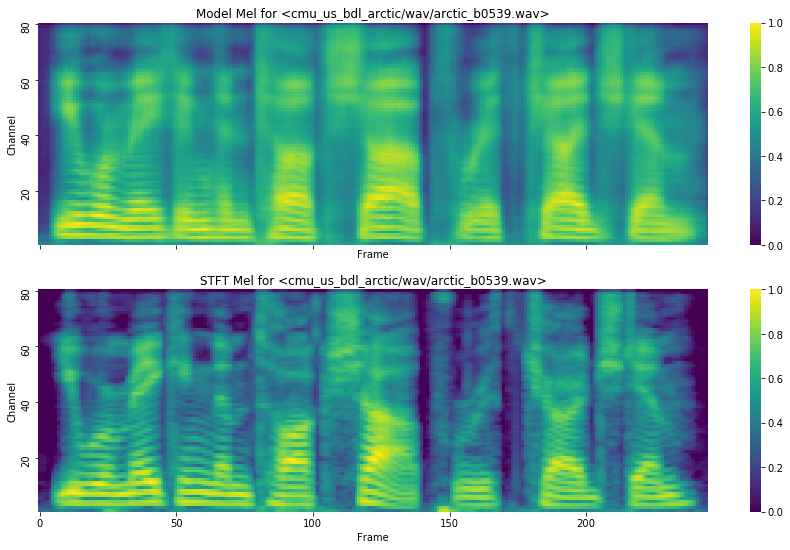

In [ ]:
m39 = preprocess_mel(path_39, tacotron_model)
draw_mel_pair(m39, path_39)

##### 2-3 查看ZHAA&YKWK模型的合成波形态

In [ ]:
hparams_zhaa = create_hparams_stage()
zhaa_path = "/home/fuu/sdb/fac-via-ppg/output/p2m/zhaa_checkpoint_19200"

zhaa_model = load_model(hparams_zhaa)
zhaa_model.load_state_dict(torch.load(zhaa_path)['state_dict'])
_ = zhaa_model.eval()

is_clip = False

Shape of model mel: (80, 412)
Shape of stft mel: (80, 411)


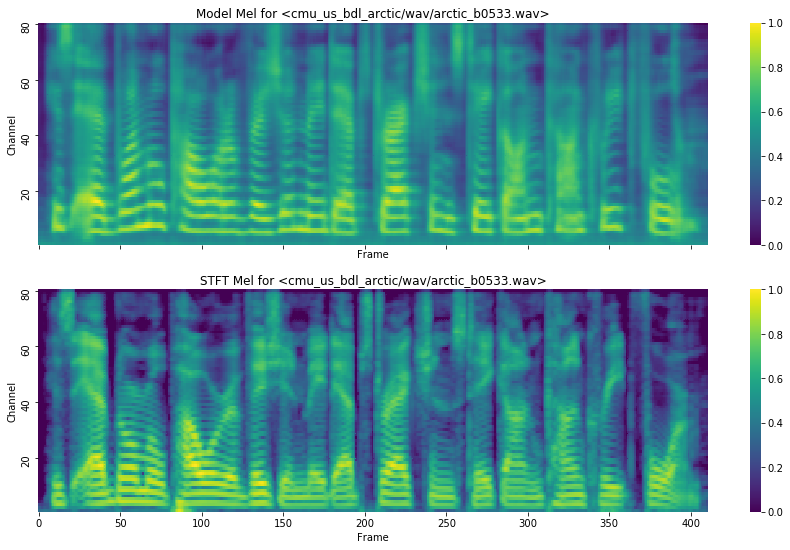

In [ ]:
zhaa33 = preprocess_mel(path_33, zhaa_model)
draw_mel_pair(zhaa33, path_33)

Shape of model mel: (80, 333)
Shape of stft mel: (80, 320)


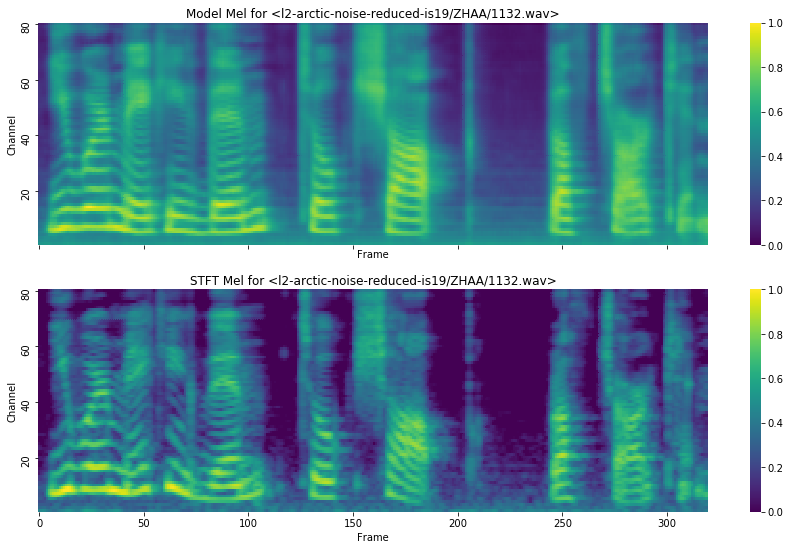

In [ ]:
path_zhaa_1132 = "/home/fuu/sdb/fac-via-ppg/data/l2-arctic-noise-reduced-is19/ZHAA/1132.wav"
zhaa1132 = preprocess_mel(path_zhaa_1132, zhaa_model)
draw_mel_pair(zhaa1132, path_zhaa_1132)

In [ ]:
# YKWK 1132
hparams_ykwk = create_hparams_stage()
ykwk_path = "/home/fuu/sdb/fac-via-ppg/output/p2m/ykwk_checkpoint_30600"

ykwk_model = load_model(hparams_ykwk)
ykwk_model.load_state_dict(torch.load(ykwk_path)['state_dict'])
_ = ykwk_model.eval()

is_clip = False

Shape of model mel: (80, 413)
Shape of stft mel: (80, 413)


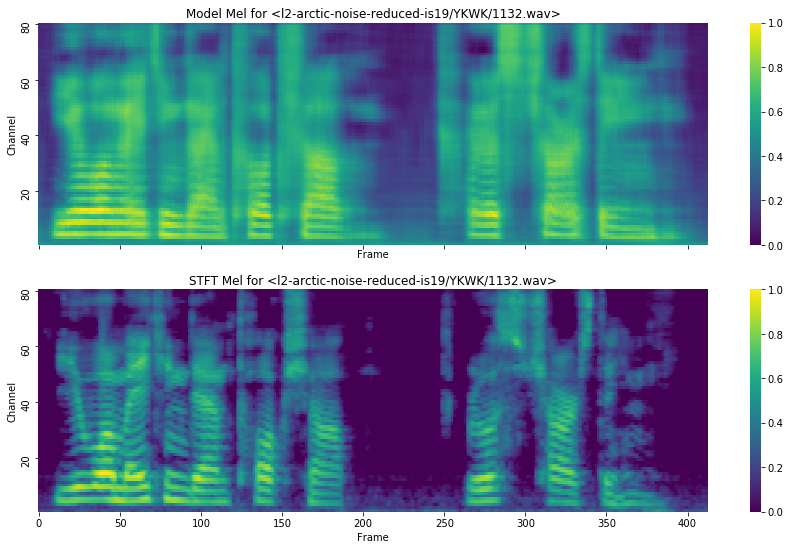

In [ ]:
path_ykwk_1132 = "/home/fuu/sdb/fac-via-ppg/data/l2-arctic-noise-reduced-is19/YKWK/1132.wav"
ykwk1132 = preprocess_mel(path_ykwk_1132, ykwk_model)
draw_mel_pair(ykwk1132, path_ykwk_1132)

##### 2-4 失败模型试验

**问题应该是PPG对于22050Hz的数据取窗的时候出错了。**

In [ ]:
import common.hparams_new as hnew
hparams_lj = hnew.create_hparams_stage()
LJ_path = "/home/fuu/sdb/fac-via-ppg/output/6_20/new_disk_22050_1200_modi/checkpoint_20400"

lj_model = load_model(hparams_lj)
lj_model.load_state_dict(torch.load(zhaa_path)['state_dict'])
_ = lj_model.eval()

is_clip = False

In [ ]:
def pmp(path, tacotron_model):
    '''
    mel from model

    Library:
        from ppg import DependenciesPPG
    '''
    is_cal = 1
    if is_cal:
        deps = DependenciesPPG()
        teacher_utt_path = path
        teacher_ppg_cal = get_ppg(teacher_utt_path, deps)
    else:
        # 从磁盘读入
        pass
    mel_ac_cal = get_inference(teacher_ppg_cal, tacotron_model)
    mel_ac_cal_S_0 = mel_ac_cal.cpu().detach().numpy()[0]
    mel_ac_cal_tS_0 = mel_ac_cal_S_0[::-1]
    
    model_mel = MaxMinNormalization(mel_ac_cal_tS_0, np.max(mel_ac_cal_tS_0), np.min(mel_ac_cal_tS_0))
    print("Shape of model mel:", np.shape(model_mel))
    
    '''mel from STFT'''
    mel_au_cal, sr = librosa.load(teacher_utt_path, sr=22050)
    mel_au_cal_S_1 = librosa.feature.melspectrogram(mel_au_cal, sr=22050, n_fft=1024, hop_length=160, n_mels=80)
    mel_au_cal_logS_1 = librosa.power_to_db(abs(mel_au_cal_S_1[::-1]))
    
    stft_mel = MaxMinNormalization(mel_au_cal_logS_1, np.max(mel_au_cal_logS_1), np.min(mel_au_cal_logS_1))
    print("Shape of stft mel:", np.shape(stft_mel))
    
    return model_mel, stft_mel

Shape of model mel: (80, 934)
Shape of stft mel: (80, 1288)


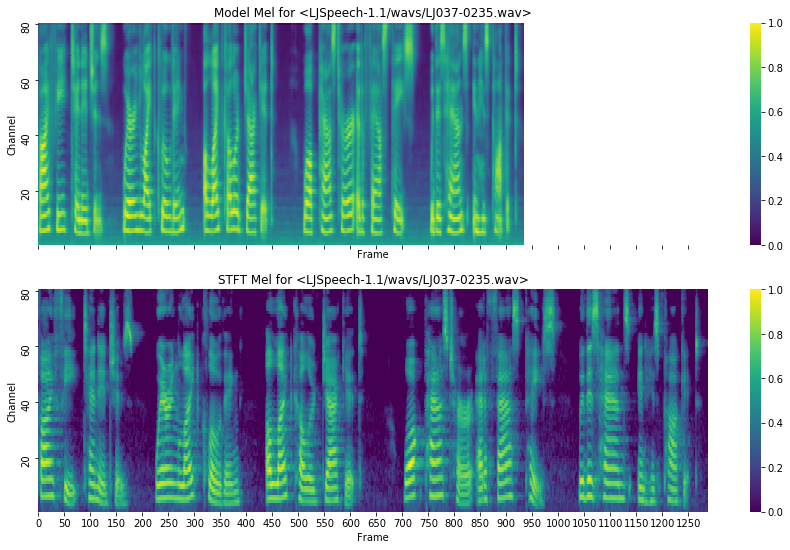

In [ ]:
path_lj_0235 = "/home/fuu/sdb/fac-via-ppg/data/LJSpeech-1.1/wavs/LJ037-0235.wav"
lj0235 = pmp(path_lj_0235, lj_model)
draw_mel_pair(lj0235, path_lj_0235)

### 0628-Ⅱ WaveGlow 模型检视

#### 1. INIT

In [ ]:
# input: 
    # mel 需要STFT
    # waveglow_model 载入
    # denoiser

In [ ]:
# STFT
from waveglow.mel2samp import Mel2Samp
from common.layers import TacotronSTFT

def load_wav_to_torch(full_path):
    """
    Loads wavdata into torch array
    """
    sampling_rate, data = wavfile.read(full_path)
    return torch.from_numpy(data).float(), sampling_rate
def get_mel_for_test(audio):
        audio_norm = audio / MAX_WAV_VALUE
        audio_norm = audio_norm.unsqueeze(0)
        audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
        stft = TacotronSTFT(filter_length=1024,
                                 hop_length=160,
                                 win_length=1024,
                                 sampling_rate=16000,
                                 mel_fmin=0.0, mel_fmax=8000.0)
        melspec = stft.mel_spectrogram(audio_norm)
#         melspec = torch.squeeze(melspec, 0)
        return melspec

def mel_via_path(file_path):
#     with open(config_path) as f:
#         data = f.read()
#     data_config = json.loads(data)["data_config"]
# #     mel2samp = Mel2Samp(**data_config)

    audio, sr = load_wav_to_torch(file_path)
    melspectrogram = get_mel_for_test(audio)
    
    return melspectrogram

MAX_WAV_VALUE = 32768.0
config_path = "/home/fuu/sdb/fac-via-ppg/src/waveglow/config_628.json"

In [ ]:
# Load mel from model
def preprocess_model_mel_for_m2w(path, tacotron_model):
    '''mel from model'''
    deps = DependenciesPPG()
    teacher_utt_path = path
    teacher_ppg_cal = get_ppg(teacher_utt_path, deps)
    mel_ac_cal = get_inference(teacher_ppg_cal, tacotron_model, is_clip)
    return mel_ac_cal

In [ ]:
# Load model
def load_waveglow_model(path):
    model = torch.load(path)['model']
    model = model.remove_weightnorm(model)
    model.cuda().eval()
    return model

waveglow_sigma = 0.6

In [ ]:
# Mel to Wave
def waveglow_audio(mel, waveglow, sigma, is_cuda_output=False):
    mel = torch.autograd.Variable(mel.cuda())
    if not is_cuda_output:
        with torch.no_grad():
            audio = 32768 * waveglow.infer(mel, sigma=sigma)[0]
        audio = audio.cpu().numpy()
        audio = audio.astype('int16')
    else:
        with torch.no_grad():
            audio = waveglow.infer(mel, sigma=sigma).cuda()
    return audio

In [ ]:
# Denoiser
from waveglow.denoiser import Denoiser

def load_denoiser(waveglow_path):
    waveglow_for_denoiser = torch.load(waveglow_path)['model']
    waveglow_for_denoiser.cuda()
    denoiser_mode = 'zeros'
    denoiser = Denoiser(waveglow_for_denoiser, mode=denoiser_mode)
    return denoiser
denoiser_strength = 0.005

#### 2. Plot Wave

In [ ]:
m2w_path = "/home/fuu/sdb/fac-via-ppg/output/6_28/bdl_m2w/waveglow_100000"
waveglow_model_100000 = load_waveglow_model(m2w_path)

In [ ]:
denoiser = load_denoiser(m2w_path)

In [ ]:
mel_wav_33 = mel_via_path(path_33)

In [ ]:
mel_wav_33.shape

torch.Size([1, 80, 411])

In [ ]:
# mel to wave
wav_bdl_0533 = waveglow_audio(mel_wav_33, waveglow_model_100000, waveglow_sigma, True)
wav_bdl_0533 = denoiser(wav_bdl_0533, strength=denoiser_strength)[:, 0].cpu().numpy().T

In [ ]:
wav_bdl_0533.T[0].shape

(65760,)

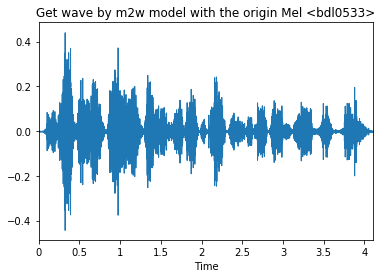

In [ ]:
plt.title("Get wave by m2w model with the origin Mel <bdl0533>")
librosa.display.waveplot(wav_bdl_0533.T[0], sr=16000)

In [ ]:
au_bdl_0533, sr = librosa.load(path_33, sr=16000)

In [ ]:
au_bdl_0533.shape

(65681,)

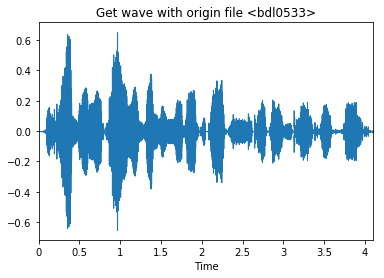

In [ ]:
plt.title("Get wave with origin file <bdl0533>")
librosa.display.waveplot(au_bdl_0533, sr=16000)

In [ ]:
mel_model_wav_33 = preprocess_model_mel_for_m2w(path_33, tacotron_model)

In [ ]:
mel_model_wav_33.shape

torch.Size([1, 80, 411])

In [ ]:
# mel to wave
wav_bdl_0533_model = waveglow_audio(mel_model_wav_33, waveglow_model_100000, waveglow_sigma, True)
wav_bdl_0533_model = denoiser(wav_bdl_0533_model, strength=denoiser_strength)[:, 0].cpu().numpy().T

In [ ]:
wav_bdl_0533_model.shape

(65760, 1)

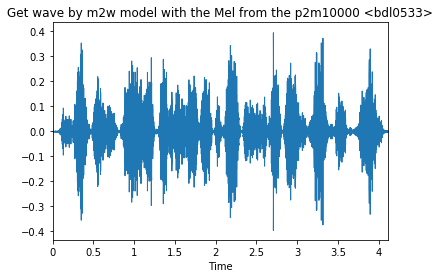

In [ ]:
plt.title("Get wave by m2w model with the Mel from the p2m10000 <bdl0533>")
librosa.display.waveplot(wav_bdl_0533_model.T[0], sr=16000)

#### 3. Output Play

In [ ]:
import IPython.display as ipd

In [ ]:
print("Get wave by m2w model with the origin mel <bdl0533>")
ipd.Audio(data=wav_bdl_0533.T[0], rate=16000)

Get wave by m2w model with the origin mel <bdl0533>


In [ ]:
print("Get wave by m2w model with the Mel from the p2m10000 <bdl0533>")
ipd.Audio(data=wav_bdl_0533_model.T[0], rate=16000)

Get wave by m2w model with the Mel from the p2m10000 <bdl0533>


In [ ]:
print("Get wave by origin file <bdl0533>")
ipd.Audio(filename=path_33, rate=16000)

Get wave by origin file <bdl0533>
